# Lecture 12
## Q 12.1
### Goal

Recreate result from paper: https://dl.acm.org/doi/pdf/10.1145/1141911.1141920

## Solution

Here's a short note about the MLS algorithm:

Suppose a series of $\{p_i\}$ and $\{q_i\}$ are given, and we want to find the transformation $T$ that maps $p_i$ to $q_i$.

consider 
$$
\Sigma_i w_i \mid l_v(p_i) - q_i \mid^2
$$

Where the weight hve the form as the following:

$$
w_i = \frac{1}{\mid l_v(p_i) - q_i \mid^2}
$$

Since $w_i$ is independent of $l_v(v)$, we can write the transformation as:

$$
l_v(x) = xM + T
$$

Taking the original optimization function, partial derivative with respect to $M$ and $T$ respectively, we have:

$$
T = q^* - p^*M
$$

Here $p^*$ and $q^*$ are the mean of $\{p_i\}$ and $\{q_i\}$ respectively (with respect to $w_i$).

So we have 
$$
l_v(x) = (x-p^*)M + q^*
$$

The original optimization function becomes:
$$
\Sigma_i w_i \mid \hat{p_i} M - \hat{q_i} \mid^2
$$

Here $\hat{p_i} = p_i - p^*$ and $\hat{q_i} = q_i - q^*$.
 

#### 1. Affine Deformation

$$
M = (\Sigma_i \hat{p_i}^T w_i \hat{p_i})^{-1} \Sigma_i \hat{p_i}^T w_i \hat{q_i}
$$

We can write the transformation into

$$
f_\alpha(v) = (v-p^*)(\Sigma_i \hat{p_i}^T w_i \hat{p_i})^{-1} \Sigma_i \hat{p_i}^T w_i \hat{q_i} + q^*
$$

Since $p_i$ is fixed in that note, we can turn this into:

$$
f_\alpha(v) = \Sigma_j A_j \hat{q_j} + q^*
$$

Where

$$
A_j = (v-p^*)(\Sigma_i \hat{p_i}^T w_i \hat{p_i})^{-1} \Sigma_i \hat{p_i}^T w_i \hat{p_j}
$$

In [21]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

Load image:

In [22]:
# load image from 'imgs/l12_toy.jpg`
image = np.array(Image.open('imgs/l12_toy.jpg'))
height, width, _ = image.shape
gridX = np.arange(width, dtype=np.int16)
gridY = np.arange(height, dtype=np.int16)
vy, vx = np.meshgrid(gridX, gridY)
# plt.imshow(image)

print(vy.shape)
print(vx.shape)
print(vy[0][5])

(315, 285)
(315, 285)
5


In [23]:
# p & q from paper definitions
_p = np.array([
    [155, 30], [155, 125], [155, 225],
    [235, 100], [235, 160], [295, 85], [293, 180]
])

_q = np.array([
    [211, 42], [155, 125], [100, 235],
    [235, 80], [235, 140], [295, 85], [295, 180]
])

p, q = _q, _p

In [24]:
eps = 1e-8
alpha = 1.0

g_row = vx.shape[0]
g_col = vx.shape[1]
p_nums = p.shape[0]

p = np.ascontiguousarray(p.astype(np.int16))
q = np.ascontiguousarray(q.astype(np.int16))

r_p = p.reshape((p_nums, 2, 1, 1))  # reshaped p
r_q = q.reshape((p_nums, 2, 1, 1))  # reshaped q
r_v = np.vstack((
    vx.reshape((1, g_row, g_col)),
    vy.reshape((1, g_row, g_col))
))

print(r_p.shape)
print(r_v.shape)
print((r_p - r_v).shape)

(7, 2, 1, 1)
(2, 315, 285)
(7, 2, 315, 285)


In [25]:
weight = 1.0 / (np.sum((r_p - r_v).astype(np.float32) ** 2, axis=1) + eps) ** alpha
weight /= np.sum(weight, axis=0, keepdims=True)  # normalize
r_weight = weight.reshape((p_nums, 1, 1, g_row, g_col))

print(weight.shape)

(7, 315, 285)


In [26]:
p_star = np.zeros((2, g_row, g_col), dtype=np.float32)
for i in range(p_nums):
    p_star += weight[i] * r_p[i]

p_hat = (r_p - p_star).reshape(
    (p_nums, 2, 1, g_row, g_col)
)
p_hat_T = p_hat.reshape(
    (p_nums, 1, 2, g_row, g_col)
)

pTwp = np.zeros((2, 2, g_row, g_col), np.float32)
for i in range(p_nums):
    pTwp += p_hat[i] * r_weight[i] * p_hat_T[i]

In [27]:
q_star = np.zeros((2, g_row, g_col), dtype=np.float32)
for i in range(p_nums):
    q_star += weight[i] * r_q[i]

In [33]:
_left = (r_v - p_star).reshape(
    (1, 2, g_row, g_col)
).transpose(
    (2, 3, 0, 1)
)

inv_pTwp = np.linalg.inv(pTwp.transpose(
    (2, 3, 0, 1))
)

wpT = np.multiply(r_weight, p_hat, out=p_hat)
_right = wpT.transpose(
    (0, 3, 4, 1, 2)
)
out_A = wpT.reshape(2, p_nums, g_row, g_col, 1, 1)[0]

A = np.matmul(
    np.matmul(_left, inv_pTwp),
    _right,
    out=out_A
).reshape(
    (p_nums, 1, g_row, g_col)
)

print(_left.shape)
print(inv_pTwp.shape)
print(_right.shape)
print(A.shape)

(315, 285, 1, 2)
(315, 285, 2, 2)
(7, 315, 285, 2, 1)
(7, 1, 315, 285)


In [29]:
transformed = np.zeros((2, g_row, g_col), dtype=np.float32)
for i in range(p_nums):
    transformed += A[i] * (r_q[i] - q_star)

transformed += q_star

# remove out of bound pixels
transformed[transformed < 0] = 0
transformed[0][transformed[0] > g_row - 1] = 0
transformed[1][transformed[1] > g_col - 1] = 0

transformed = transformed.astype(np.int16)

In [30]:
affine_deformed = np.ones_like(image)
affine_deformed[vx, vy] = image[tuple(transformed)]

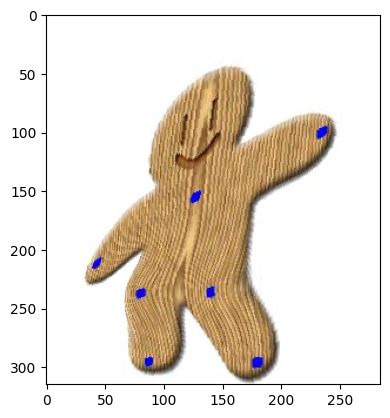

In [31]:
plt.imshow(affine_deformed)